In [26]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import traceback

def rk45(odefun, tspan, yini, options):
    """
    Runge-Kutta-Fehlberg 4(5) implementation for autonomous systems
    +------------++------------+------------+------------+------------+------------+------------+
    |     0      ||            |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/4     ||    1/4     |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    3/8     ||    3/32    |    9/32    |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |   12/13    || 1932/2197  | -7200/2197 | 7296/2197  |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |     1      ||  439/216   |     -8     |  3680/513  | -845/4104  |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/2     ||   -8/27    |     2      | -3544/2565 | 1859/4104  |   -11/40   |            |
    +------------++------------+------------+------------+------------+------------+------------+
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(5)    ||   16/135   |     0      | 6656/12825 |28561/56430 |   -9/50    |    2/55    |
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(4)    ||   25/216   |     0      | 1408/2565  | 2197/4104  |    -1/5    |     0      |
    +------------++------------+------------+------------+------------+------------+------------+
    """

    try:
        c       = np.zeros(6)
        c[:]    = [      0      ,     1/4    ,     3/8    ,    12/13   ,     1      ,     1/2    ]

        a       = np.zeros((6, 6))
        a[:,:]  = [[     0      ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    1/4     ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    3/32    ,    9/32    ,      0     ,      0     ,      0     ,      0     ],
                   [ 1932/2197  , -7200/2197 , 7296/2197  ,      0     ,      0     ,      0     ],
                   [  439/216   ,     -8     ,  3680/513  , -845/4104  ,      0     ,      0     ],
                   [   -8/27    ,     2      , 3544/2565 , 1859/4104  ,   -11/40   ,      0     ]]


        b       = np.zeros((2, 6))
        b[:,:]  = [[   16/135   ,     0      , 6656/12825 ,28561/56430 ,   -9/50    ,    2/55    ],
                   [   25/216   ,     0      , 1408/2565  , 2197/4104  ,    -1/5    ,     0      ]]

        # store the number of variables
        n       = len(yini)
        nstages = 6

        # check the existence of abstol and reltol
        if 'abstol' in options:
            abstol = options['abstol']
        else:
            abstol = 1.0e-4

        if 'reltol' in options:
            reltol = options['reltol']
        else:
            reltol = 1.0e-4

        # check for the existence of count of checkpoints
        if 'numcheckpoints' in options:
            numcheckpoints = options['numcheckpoints']
        else:
            numcheckpoints = 10

        # reset values of nacc and nrej
        options['nacc'] = 0
        options['nrej'] = 0

        # now divide up the interval with numcheckpoints
        timepoints = np.linspace(tspan[0], tspan[1], numcheckpoints + 1)

        print(timepoints)

        # create solution trajectory
        trajectory = np.zeros((n, numcheckpoints + 1))

        # store the initial solution
        trajectory[:, 0] = yini

        # stage values
        Y = np.zeros((n, nstages))

        # f values
        K = np.zeros((n, nstages))

        # store yini and compute fini
        Y[:, 0] = yini
        K[:, 0] = odefun(Y[:, 0])

        # Get h value from options if it exists
        if 'h' in options:
            h = options['h']
        else:
            h = 1.0e-6

        # get the machine epsilon
        eps = np.spacing(1)

        # rounding
        roundoff = eps/2.0
            
        # get the initial time
        t   = tspan[0]

        # get the final time
        tf  = tspan[1]

        # index for comparison against timepoints
        # to store trajectory when it exceeds this
        # or equals it
        i   = 0

        # safety factor
        fac = 0.8
        #for data set
        featureh = []
        validwind = []
        p = 0
        while tf - t - roundoff >= 0: #and p < 1000:
            if tf - t <= 10 * roundoff * abs(tf):
                break
            print_progress(int(t/tf*100), 100)
            for s in range(nstages - 1):
                Y[:, s + 1] = Y[:, 0] + h * K.dot(a[s + 1, :])
                K[:, s + 1] = odefun(Y[:, s + 1])

            # final output and error
            yfin = Y[:, 0] + h * K.dot(b[0, :])
            yerr = h * K.dot((b[0, :] - b[1, :]))
            
            # find the scaling factor            
            sc   = abstol + np.maximum(np.abs(Y[:, 0]), np.abs(yfin)) * reltol

            # compute the error
            err  = max(np.sqrt(np.sum((yerr / sc)**2)/n), 1.0e-10)

            # accept or reject
            if err <= 1:
                # accept
                # now store the final output as next step ini
                Y[:, 0] = yfin
                K[:, 0] = odefun(Y[:, 0])
                #creating the data set
                featureh.append(h)
                validwind.append(1)
                # store the solution
                if t + h - timepoints[i + 1] >= 0 or tf - t - h <= 10 * roundoff * abs(tf):
                    i                = i + 1
                    trajectory[:, i] = yfin

                # increment time by h
                t = t + h

                # increment the count of accepted steps
                options['nacc'] += 1

                # compute the new h for next timestep
                h = h * min(1.5, max(0.2, fac * (1/err)**(1/5)))
                p +=1
                #print(p)
            else:
                # reject
                #creating the data set
                featureh.append(h)
                validwind.append(0)
                # increment the count of rejected steps
                options['nrej'] += 1
                
                # compute the new h for next timestep
                h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))

        return trajectory[:, :i], featureh, validwind
    except BaseException as e:
        print(traceback.print_exc()) 


In [27]:
# -*- coding: utf-8 -*-
# from gist: https://gist.github.com/aubricus/f91fb55dc6ba5557fbab06119420dd6a
import sys

# Print iterations progress
def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar

    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()


In [28]:
import numpy as np
import functools as ft

def InitializeModel():
    #  Solves the Allen Cahn problem from 
    #  M.P. Calvo and A. Gerisch.
    #  Linearly implicit Runge-Kutta methods and approximate matrix 
    #  factorization. Applied Numerical Mathematics,
    #  53(2):183-200, 2005.

    # Parameters defining the RHS behavior.
    myalpha = 1
    mygamma = 10

    # Grid size in x and y
    M = 128
    N = 128

    # Suggested integration information.
    Tspan = np.array([0, 0.075])
    dt_integration = 0.002

    # linear representation of x and y variables
    x = np.linspace(0,1,M)
    y = np.linspace(0,1,N)

    # Grid representation of x and y.
    X, Y = np.meshgrid(x,y)

    # grid representation of initial condition.
    u0 = 0.4 + 0.1 * (X + Y) + 0.1 * (np.sin(10*X) * np.sin(20*Y))
    
    # grid representation of boundary values corresponding to the intitial condition.
    bound  = lambda i,j,dx,dy: (0.4 + 0.1 * ((j - 1) * dx + (i - 1) * dy) + 
                               0.1 * (np.sin(10 * (j - 1) * dx) * np.sin(20 * (i - 1) *dy)))

    # linear representation of initial condition.
    y0     = np.reshape(u0, M*N)
    
    # RHS and Jacobian function calls, in MATLAB standard form.
    rhsFun = ft.partial(AllenCahnNeumann, M=M, N=N, alpha=myalpha, gamma=mygamma, bound=bound)

    model  = {'rhsFun': rhsFun,
             'y0':     y0,
             'Tspan':  Tspan,
             'dt':     dt_integration,
             'M':      M,
             'N':      N,
             'alpha':  myalpha,
             'gamma':  mygamma}

    return model
             
    
def AllenCahnNeumann(u, M, N, alpha, gamma, bound):
    dx = 1.0/(N-1)
    dy = 1.0/(M-1)
    f  = np.zeros(M*N)
    
    for i in range(1, M+1):
        for j in range(1, N+1):        
            self = i + M * (j - 1) - 1 

            if ( i == 1 ):
                down = u[self] - dy * bound(i, j, dx, dy)
            else:
                down = u[i - 1 + M * (j - 1) - 1]
                
            if ( i == M ):
                up = u[self] + dy * bound(i,j,dx,dy)
            else:
                up = u[i + 1 + M * (j - 1) - 1]
        
            if ( j == 1 ):
                left = u[self] - dx * bound(i,j,dx,dy)
            else:
                left = u[i + M * (j - 2) - 1]
        
            if ( j == N ):
                right = u[self] + dx * bound(i,j,dx,dy)
            else:
                right = u[i + M * j - 1]
        
            uself = u[self]
            
            f[self] = alpha * (1.0/dy**2 * (up    - 2 * uself + down)  + \
                               1.0/dx**2 * (right - 2 * uself + left)) + gamma * (uself - uself**3)
            
    return f





In [59]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
start_time = time.time()

if __name__ == "__main__":

    # # linear problem
    # odefun                    = lambda y: -y/2
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0, 1.0]
    # y0                        = [2, 1.0]

    # oscillatory problem
    # odefun                    = lambda y: [-np.sin(y[2]), -100 * np.sin(100*y[2]), 1] 
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0.0, 2 * math.pi]
    # y0                        = [1.0, 1.0, 0]
    
    # Allen Cahn
    #import allen_cahn as ac
    model = InitializeModel()
    #odefun                    = lambda y: model['rhsFun'](y)
    odefun                    = lambda y: [-np.sin(y[2]),-100 * np.sin(100*y[1]),y[0]]
    options                   = {}
    options['abstol']         = 1.0e-6
    options['reltol']         = 1.0e-6
    options['h']              = 1.0e-6
    options['numcheckpoints'] = 1000
    #tspan                     = [0.0, 0.3]
    tspan                     = [0, math.pi]
    #y0                        = model['y0']
    y0                        = [1.0, 1.0,0]

    trajectory, featureh, validwind= rk45(odefun, tspan, y0, options)
    
    # print number of accepted/rejected steps'
    print('\n')
    print("Accepted Steps:" + str(options['nacc']))
    print("Rejected Steps:" + str(options['nrej']))
    print("Time: %s seconds" % (time.time() - start_time))

[0.         0.00314159 0.00628319 ... 3.13530947 3.13845106 3.14159265]
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

Accepted Steps:6957
Rejected Steps:1073
Time: 8.47316312789917 seconds


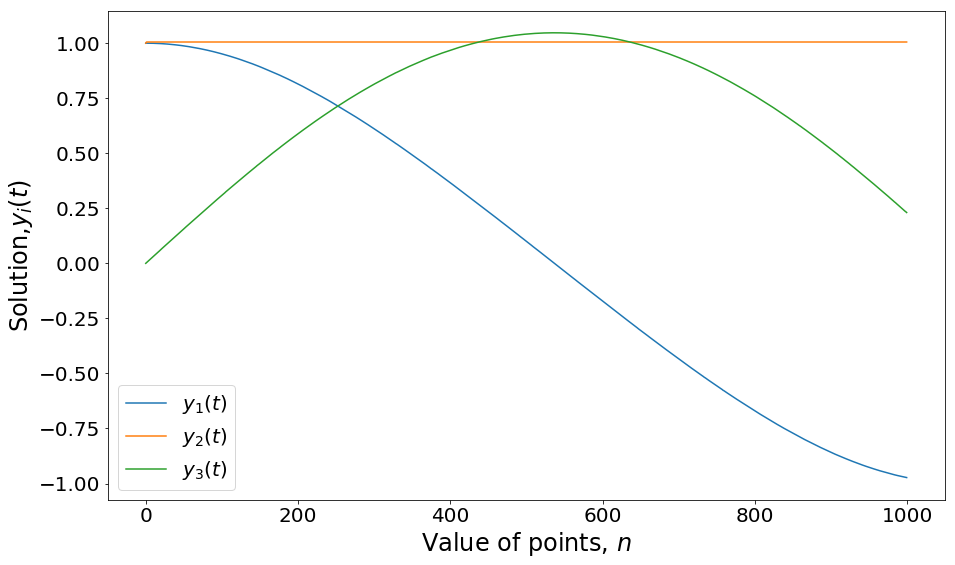

In [60]:
    # Plot trajectory
    n = len(y0)

    # create a figure
    plt.figure(figsize=(15,9))
    lbl = ["$y_1(t)$","$y_2(t)$","$y_3(t)$"]
    for i in range(3):
        plt.plot(trajectory[i, :],label=lbl[i])
    plt.xlabel("Value of points, $n$", fontsize=24)
    plt.ylabel("Solution,$y_i(t)$", fontsize=24)
    plt.legend(loc="best", fontsize=20)
    plt.xticks(fontsize = 20)
    _ = plt.yticks(fontsize = 20)
    #plt.savefig('NM_auto.png')
    plt.show()

In [30]:
from sklearn.linear_model import LinearRegression
featureh = np.array(featureh)
#fitting a model
reg = LinearRegression().fit(featureh.reshape(-1,1), validwind)
from sklearn.externals import joblib
#saving model to use later
joblib.dump(reg, 'easy_eq.joblib')

0.970164842873954

In [35]:
#the same integration method but with prediction
def rk45ML(odefun, tspan, yini, options):
    """
    Runge-Kutta-Fehlberg 4(5) implementation for autonomous systems
    +------------++------------+------------+------------+------------+------------+------------+
    |     0      ||            |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/4     ||    1/4     |            |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    3/8     ||    3/32    |    9/32    |            |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |   12/13    || 1932/2197  | -7200/2197 | 7296/2197  |            |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |     1      ||  439/216   |     -8     |  3680/513  | -845/4104  |            |            |
    +------------++------------+------------+------------+------------+------------+------------+
    |    1/2     ||   -8/27    |     2      | -3544/2565 | 1859/4104  |   -11/40   |            |
    +------------++------------+------------+------------+------------+------------+------------+
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(5)    ||   16/135   |     0      | 6656/12825 |28561/56430 |   -9/50    |    2/55    |
    +------------++------------+------------+------------+------------+------------+------------+
    |    O(4)    ||   25/216   |     0      | 1408/2565  | 2197/4104  |    -1/5    |     0      |
    +------------++------------+------------+------------+------------+------------+------------+
    """

    try:
        c       = np.zeros(6)
        c[:]    = [      0      ,     1/4    ,     3/8    ,    12/13   ,     1      ,     1/2    ]

        a       = np.zeros((6, 6))
        a[:,:]  = [[     0      ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    1/4     ,      0     ,      0     ,      0     ,      0     ,      0     ],
                   [    3/32    ,    9/32    ,      0     ,      0     ,      0     ,      0     ],
                   [ 1932/2197  , -7200/2197 , 7296/2197  ,      0     ,      0     ,      0     ],
                   [  439/216   ,     -8     ,  3680/513  , -845/4104  ,      0     ,      0     ],
                   [   -8/27    ,     2      , 3544/2565 , 1859/4104  ,   -11/40   ,      0     ]]


        b       = np.zeros((2, 6))
        b[:,:]  = [[   16/135   ,     0      , 6656/12825 ,28561/56430 ,   -9/50    ,    2/55    ],
                   [   25/216   ,     0      , 1408/2565  , 2197/4104  ,    -1/5    ,     0      ]]

        # store the number of variables
        n       = len(yini)
        nstages = 6

        # check the existence of abstol and reltol
        if 'abstol' in options:
            abstol = options['abstol']
        else:
            abstol = 1.0e-4

        if 'reltol' in options:
            reltol = options['reltol']
        else:
            reltol = 1.0e-4

        # check for the existence of count of checkpoints
        if 'numcheckpoints' in options:
            numcheckpoints = options['numcheckpoints']
        else:
            numcheckpoints = 10

        # reset values of nacc and nrej
        options['nacc'] = 0
        options['nrej'] = 0

        # now divide up the interval with numcheckpoints
        timepoints = np.linspace(tspan[0], tspan[1], numcheckpoints + 1)

        print(timepoints)

        # create solution trajectory
        trajectory = np.zeros((n, numcheckpoints + 1))

        # store the initial solution
        trajectory[:, 0] = yini

        # stage values
        Y = np.zeros((n, nstages))

        # f values
        K = np.zeros((n, nstages))

        # store yini and compute fini
        Y[:, 0] = yini
        K[:, 0] = odefun(Y[:, 0])

        # Get h value from options if it exists
        if 'h' in options:
            h = options['h']
        else:
            h = 1.0e-6

        # get the machine epsilon
        eps = np.spacing(1)

        # rounding
        roundoff = eps/2.0
            
        # get the initial time
        t   = tspan[0]

        # get the final time
        tf  = tspan[1]

        # index for comparison against timepoints
        # to store trajectory when it exceeds this
        # or equals it
        i   = 0

        # safety factor
        fac = 0.8
        #data
        p = 0
        while tf - t - roundoff >= 0: #and p < 1000:
            if tf - t <= 10 * roundoff * abs(tf):
                break
            print_progress(int(t/tf*100), 100)
            for s in range(nstages - 1):
                Y[:, s + 1] = Y[:, 0] + h * K.dot(a[s + 1, :])
                K[:, s + 1] = odefun(Y[:, s + 1])

            # final output and error
            yfin = Y[:, 0] + h * K.dot(b[0, :])
            yerr = h * K.dot((b[0, :] - b[1, :]))
            
            # find the scaling factor            
            sc   = abstol + np.maximum(np.abs(Y[:, 0]), np.abs(yfin)) * reltol

            # compute the error
            err  = max(np.sqrt(np.sum((yerr / sc)**2)/n), 1.0e-10)

            # accept or reject
            if err <= 1:
                # accept
                # now store the final output as next step ini
                Y[:, 0] = yfin
                K[:, 0] = odefun(Y[:, 0])
                # store the solution
                if t + h - timepoints[i + 1] >= 0 or tf - t - h <= 10 * roundoff * abs(tf):
                    i                = i + 1
                    trajectory[:, i] = yfin

                # increment time by h
                t = t + h

                # increment the count of accepted steps
                options['nacc'] += 1

                # compute the new h for next timestep
                h = h * min(1.5, max(0.2, fac * (1/err)**(1/5)))
                #will the next step be accepted?
                acceptnext = reg.predict(np.array([[h]]))[0]
                #if not, shrink the step size
                while acceptnext < 1:
                    h = 0.9*h
                    acceptnext = reg.predict(np.array([[h]]))[0]
            else:
                # reject
                # increment the count of rejected steps
                options['nrej'] += 1
                # compute the new h for next timestep
                h = h * min(1.0, max(0.2, fac * (1/err)**(1/5)))
                #will the next step be accepted?
                acceptnext = reg.predict(np.array([[h]]))[0]
                #if not, shrink the step size
                while acceptnext < 1:
                    h = 0.9*h
                    acceptnext = reg.predict(np.array([[h]]))[0]

        return trajectory[:, :i]
    except BaseException as e:
        print(traceback.print_exc()) 


In [37]:
#for test model from different method
reg1 = joblib.load('easy_eq_my.joblib')

In [63]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
start_time = time.time()

if __name__ == "__main__":

    # # linear problem
    # odefun                    = lambda y: -y/2
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0, 1.0]
    # y0                        = [2, 1.0]

    # oscillatory problem
    # odefun                    = lambda y: [-np.sin(y[2]), -100 * np.sin(100*y[2]), 1] 
    # options                   = {}
    # options['abstol']         = 1.0e-6
    # options['reltol']         = 1.0e-6 
    # options['numcheckpoints'] = 100
    # tspan                     = [0.0, 2 * math.pi]
    # y0                        = [1.0, 1.0, 0]
    
    # Allen Cahn
    #import allen_cahn as ac
    model = InitializeModel()
    #odefun                    = lambda y: model['rhsFun'](y)
    odefun                    = lambda y: [-np.sin(y[2]),-100 * np.sin(100*y[1]),y[0]]
    options                   = {}
    options['abstol']         = 1.0e-6
    options['reltol']         = 1.0e-6
    options['h']              = 1.0e-6
    options['numcheckpoints'] = 1000
    options['model']          = reg
    #tspan                     = [0.0, 0.3]
    tspan                     = [0, math.pi]
    #y0                        = model['y0']
    y0                        = [1.0, 1.0,0]

    trajectory = rk45ML(odefun, tspan, y0, options)
    
    # print number of accepted/rejected steps
    print('\n')
    print("Accepted Steps:" + str(options['nacc']))
    print("Rejected Steps:" + str(options['nrej']))
    print("Time: %s seconds" % (time.time() - start_time))

[0.         0.00314159 0.00628319 ... 3.13530947 3.13845106 3.14159265]
 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

Accepted Steps:8498
Rejected Steps:0
Time: 13.505298852920532 seconds


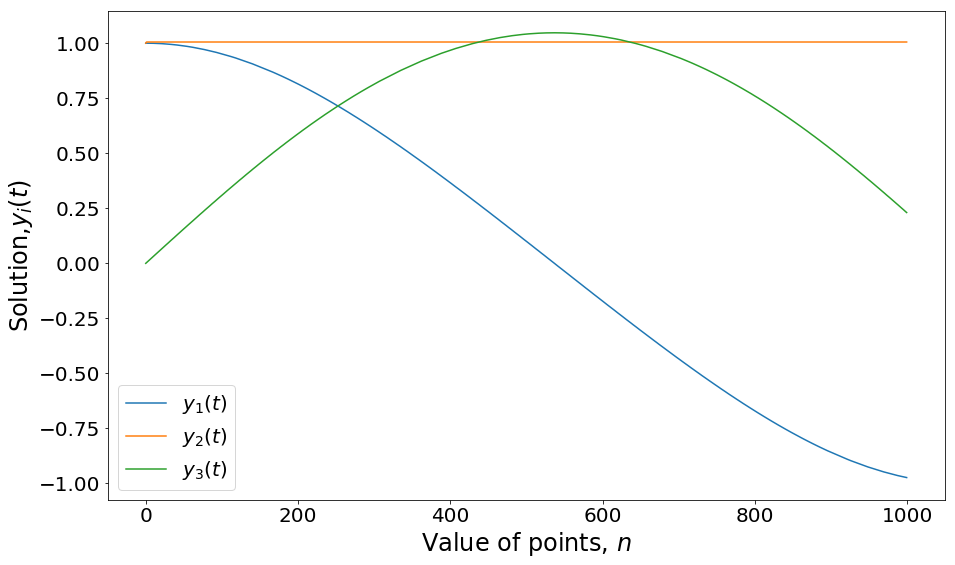

In [64]:
    # Plot trajectory
    n = len(y0)

    # create a figure
    plt.figure(figsize=(15,9))
    lbl = ["$y_1(t)$","$y_2(t)$","$y_3(t)$"]
    for i in range(3):
        plt.plot(trajectory[i, :],label=lbl[i])
    plt.xlabel("Value of points, $n$", fontsize=24)
    plt.ylabel("Solution,$y_i(t)$", fontsize=24)
    plt.legend(loc="best", fontsize=20)
    plt.xticks(fontsize = 20)
    _ = plt.yticks(fontsize = 20)
    #plt.savefig('NM_auto.png')
    plt.show()